In [8]:
import torch 
def NMS(boxes, scores, iou_threshold):
    # [x1, y1, width, height] 
    global selected_boxes
    scores = list(scores)
    order = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
    
    x1, y1, width, height = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x2 = x1 + width
    y2 = y1 + height
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    out = []
    discarded_iou_map = {}

    while len(order) > 0:
        i = order[0]  
        out.append(i)

        if len(order) == 1:
            break
        
        xx1 = torch.max(x1[i], x1[torch.tensor(order[1:])])
        yy1 = torch.max(y1[i], y1[torch.tensor(order[1:])])
        xx2 = torch.min(x2[i], x2[torch.tensor(order[1:])])
        yy2 = torch.min(y2[i], y2[torch.tensor(order[1:])])
        
        inter = (xx2 - xx1 + 1).clamp(min=0) * (yy2 - yy1 + 1).clamp(min=0)
        iou = inter / (areas[i] + areas[torch.tensor(order[1:])] - inter)
        
        # Record IoU values for discarded boxes
        for idx, iou_value in zip(order[1:], iou.tolist()):
            if iou_value > iou_threshold:
                discarded_iou_map[idx] = iou_value
        
        remaining_indices = [j for j, iou_value in enumerate(iou.tolist()) if iou_value <= iou_threshold]
        order = [order[j + 1] for j in remaining_indices]

    selected_boxes = boxes[out]
    return selected_boxes, out, discarded_iou_map


In [9]:
'''Expected Behavior

    Box 1 is small and has a high score of 0.9.
    Box 2 is large and overlaps with Box 1 and Box 3.
    Box 3 has a medium score (0.8) and overlaps with Box 2, but has less overlap with Box 1.
    Given an IOU threshold of 0.7, Box 1 should be retained because of its high score and minimal overlap with the other boxes.
    Box 3 should be kept due to its score of 0.8 and lesser overlap with the others compared to Box 2.
    Box 2 may be suppressed because of its large overlap with Box 3 and Box 1.'''

# Define the bounding boxes and scores
boxes = torch.tensor([[100, 100, 10, 10],  # Box 1
                      [100, 100, 9, 9],  # Box 2
                      [150, 150, 250, 250]])  # Box 3

scores = torch.tensor([0.9, 0.75, 0.2])  # Corresponding scores

# Apply Non-Maximum Suppression with IOU threshold of 0.7
keep_indices = NMS(boxes, scores, iou_threshold=0.7)

# Print the indices of the boxes that are kept
print(keep_indices)


(tensor([[100, 100,  10,  10],
        [150, 150, 250, 250]]), [0, 2], {1: 0.8264462947845459})


In [19]:
# visualizer NMS 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plot_boxes_nms(boxes, scores, selected_indices, discarded_iou_map, iou_threshold):
    """
    Visualizes the original boxes and the results of NMS with clear IoU annotations and a legend.

    Parameters:
    - boxes: Tensor of shape (N, 4), all boxes as [x, y, width, height].
    - scores: List or tensor of scores for each box.
    - selected_indices: List of indices of boxes selected by NMS.
    - discarded_iou_map: Dict mapping discarded box indices to IoU with the corresponding selected box.
    - iou_threshold: IoU threshold used for NMS.
    """
    # Convert tensors to numpy for compatibility with matplotlib
    boxes = boxes.numpy()
    scores = np.array(scores)
    selected_indices_set = set(selected_indices)  # Convert to set for faster lookup

    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # Left: All boxes in blue
    axes[0].set_title("All Boxes")
    axes[0].set_xlim(0, max(boxes[:, 0] + boxes[:, 2]) + 10)
    axes[0].set_ylim(0, max(boxes[:, 1] + boxes[:, 3]) + 10)
    axes[0].invert_yaxis()  # Invert y-axis for image-like coordinates
    for i, box in enumerate(boxes):
        x, y, w, h = box
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='blue', facecolor='none')
        axes[0].add_patch(rect)
    # Add legend for all boxes
    blue_patch = patches.Patch(color='blue', label='All Boxes')
    axes[0].legend(handles=[blue_patch], loc='upper right')

    # Right: NMS results (selected in green, discarded in red)
    axes[1].set_title("NMS Results")
    axes[1].set_xlim(0, max(boxes[:, 0] + boxes[:, 2]) + 10)
    axes[1].set_ylim(0, max(boxes[:, 1] + boxes[:, 3]) + 10)
    axes[1].invert_yaxis()
    for i, box in enumerate(boxes):
        x, y, w, h = box
        if i in selected_indices_set:  # Selected boxes in green
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='green', facecolor='none')
            axes[1].add_patch(rect)
            # Add the score as text
            axes[1].text(x + w / 2, y - 5, f"{scores[i]:.2f}", color='green', fontsize=8, ha='center')
        else:  # Discarded boxes in red
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='red', facecolor='none')
            axes[1].add_patch(rect)
            # Add IoU as text if available
            discarded_iou = discarded_iou_map.get(i, None)
            if discarded_iou is not None:
                axes[1].text(x + w / 2, y - 5, f"IoU: {discarded_iou:.2f}", color='red', fontsize=8, ha='center')

    # Add legend for NMS Results panel
    green_patch = patches.Patch(color='green', label='Selected Boxes')
    red_patch = patches.Patch(color='red', label='Discarded Boxes')
    axes[1].legend(handles=[green_patch, red_patch], loc='upper right')

    plt.tight_layout()
    plt.show()



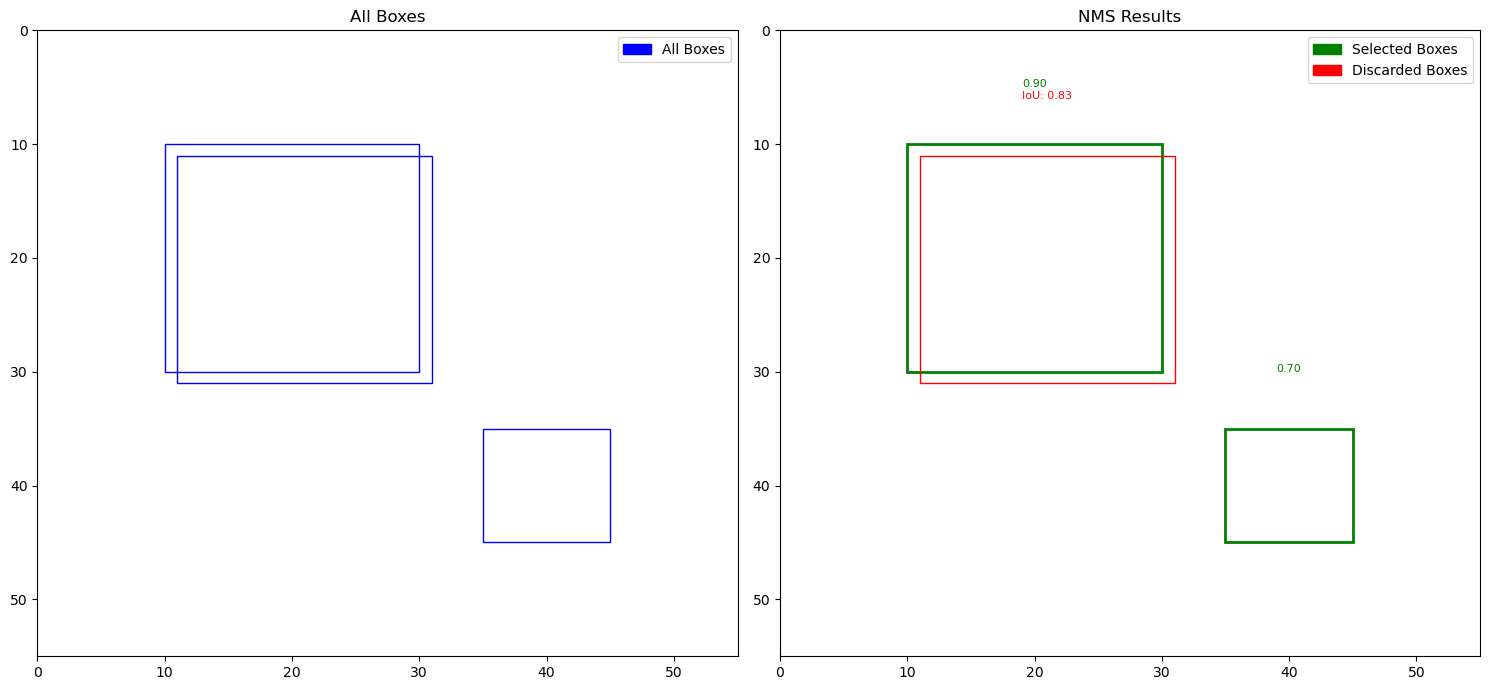

In [20]:
# Example data
boxes = torch.tensor([[10, 10, 20, 20],
                      [11, 11, 20, 20],
                      [35, 35, 10, 10]])
scores = torch.tensor([0.9, 0.8, 0.7])
iou_threshold = 0.8

# Run NMS
selected_boxes, selected_indices, discarded_iou_map = NMS(boxes, scores, iou_threshold)

# Plot results
plot_boxes_nms(boxes, scores, selected_indices, discarded_iou_map, iou_threshold)


In [8]:
def compute_iou(box1, box2):
    # input of boxes [x, y, width, height] for box1, [xmin, ymin, xmax, ymax] for box2
    x1, y1, w1, h1 = box1
    xmin2, ymin2, xmax2, ymax2 = box2

    # Convert box1 to [x_min, y_min, x_max, y_max]
    box1_xmax = x1 +w1 
    box1_ymax =  y1 + h1

    # Compute intersection coordinates
    inter_x1 = max(x1, xmin2)
    inter_y1 = max(y1, ymin2)
    inter_x2 = min(box1_xmax, xmax2)
    inter_y2 = min(box1_ymax, ymax2)

    # Compute intersection area
    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)

    # Compute areas of both boxes
    box1_area = w1 * h1
    box2_area = (xmax2 - xmin2) * (ymax2 - ymin2)

    # Compute union area
    union_area = box1_area + box2_area - inter_area

    # Compute IoU
    iou = inter_area / union_area if union_area > 0 else 0
    return iou



In [9]:
import numpy
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def mAP(pred_boxes, gt_boxes, iou_threshold):
    # Input prd: [x,y,width, height]
    # Input gt: [xmin, ymin, xmax, ymax] 
    y_true = []
    y_score = []
    matched_gt = {class_id: [False] * len(gt) for class_id, gt in enumerate(gt_boxes)}

    for pred in pred_boxes:
        x, y, w, h, score, class_id = pred
        matched = False
        best_match_idx = -1
        best_iou = 0.0

        if class_id < len(gt_boxes):
            for idx, gt in enumerate(gt_boxes[class_id]):
                if not matched_gt[class_id][idx]:  # Check if this GT box is not already matched
                    iou = compute_iou([x, y, w, h], gt)
                    if iou >= iou_threshold and iou > best_iou:
                        best_iou = iou
                        best_match_idx = idx
                        matched = True

            if matched:
                matched_gt[class_id][best_match_idx] = True
                y_true.append(1)  # True positive
            else:
                y_true.append(0)  # False positive
            y_score.append(score)

    # Handle unmatched ground truths (false negatives)
    for class_id, gt_list in enumerate(matched_gt):
        for matched in matched_gt[class_id]:
            if not matched:
                y_true.append(0)  # False negative
                y_score.append(0)  # Add a low score for completeness

    precision, recall, _ = precision_recall_curve(y_true, y_score)

    # Plotting Precision-Recall curve
    plt.plot(recall, precision, linewidth=4, color="red", zorder=0)
    plt.xlabel("Recall", fontsize=12, fontweight='bold')
    plt.ylabel("Precision", fontsize=12, fontweight='bold')
    plt.title("Precision-Recall Curve", fontsize=15, fontweight="bold")
    plt.show()

    # Append to precision and recall
    precision = numpy.concatenate((precision, [1]))
    recall = numpy.concatenate((recall, [0]))

    # Calculate Average Precision (AP)
    AP = numpy.sum((recall[:-1] - recall[1:]) * precision[:-1])
    print(AP)

    print("y_true:", y_true)
    print("y_score:", y_score)

    return AP

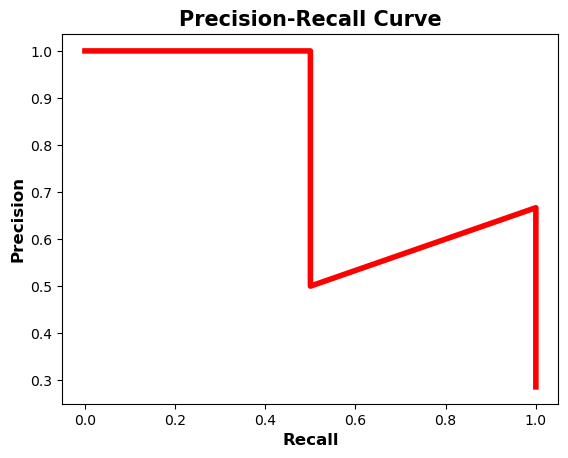

0.8333333333333333
y_true: [1, 1, 0, 0, 0, 0, 0]
y_score: [0.9, 0.75, 0.6, 0.8, 0.5, 0.4, 0]
Mean Average Precision (mAP): 0.8333333333333333


In [10]:
## Test example
pred_boxes = [
    [50, 50, 100, 100, 0.9, 0],     # Format changed to [x, y, width, height, score, class_id]
    [55, 60, 100, 100, 0.75, 0],    
    [200, 200, 100, 100, 0.6, 0],   

    [30, 30, 90, 90, 0.8, 1],       
    [40, 40, 90, 90, 0.5, 1],       
    [300, 300, 100, 100, 0.4, 1],   
]

gt_boxes = [
    [[50, 50, 150, 150], [60, 60, 160, 160]],  # Format updated to [xmin, ymin, xmax, ymax]
    [[50, 30, 120, 120]],                       
]

# Run mAP calculation
mAP_value = mAP(pred_boxes, gt_boxes, 0.9)  # Setting IoU threshold to 0.5 for a more realistic match
print("Mean Average Precision (mAP):", mAP_value)